<a href="https://colab.research.google.com/github/baschram/bda-718-group-1/blob/master/Fleet_Classification_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pyspark Install and Drive Mounting

In [ ]:
%%bash
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark
pip install seaborn

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=9ffe9344b6fd6c49be3862723ab23e7449318c26569712f82d8966db9203c15c
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


Import required spark packages and set spark environment to use additoinal memory and cores on colab instance

In [ ]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
import re
from pyspark.sql import functions as fn
from pyspark.sql.functions import col, regexp_replace, split
from pyspark.sql.utils import AnalysisException
from pyspark.sql import Row
from pyspark.sql.types import IntegerType, DateType, FloatType, BooleanType
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "12g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","12g")\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data load and processing

Initial data load and cleaning.  Code replicaed from intial EDA file

Remove aany duplicate entires
Drop columns with no data or are redundant infromation
Regex replace to remove "--" and "None" fields for better NA processing

Series of regex replace operations to remove unneeded text from data columns

Change all text to lower case for consistency

Decompose the torque column to list torque and rpm as two seperate columns

Featute engineer torque grade column by dividing torque by rpm

recast data types of columns

Replaced NA with the dominant value of the column for categorical features

Replaced NAs with means of continuous variables with high standard deviation

Replaced NA with median for continous variables with low standard deviation


In [ ]:
sampled_df = spark.read.format("csv").option("header", "true").option('inferSchema','true').load("drive/Shared drives/IST 718 Group1/sampled_used_cars_data_nodesc.csv")

# EDA: Duplicate Data Removal
sampled_df = sampled_df.distinct()

# Drop the index column
# Drop exterior color ,power, and wheel system displacement (redundant columns)
# Drop Bed height (no values)
sampled_df = sampled_df.drop(*['power','main_picture_url',
                               'combine_fuel_economy', 'listing_id',
                               'vehicle_damage_category','trimId',
                               'trim_name','exterior_color','wheel_system_display','bed_height','power','is_certified'])

# Generate of list of column names for future use
colList = sampled_df.columns
numColList = []
catColList = []

#Needs to occur prior to data type casting as the loop will convert columns back to strings
for x in sampled_df.columns:
  sampled_df = sampled_df.withColumn(x, regexp_replace(col(x),r'--',''))
  sampled_df = sampled_df.withColumn(x, regexp_replace(col(x),r'None',''))

#Column cleaning and type casting

#Function to check if column exists or not
def has_column(df, col):
    try:
        df[col]
        return True
    except AnalysisException:
        return False

sampled_df = sampled_df.withColumn('back_legroom',
                                   regexp_replace(col('back_legroom'),r'\sin',''))
sampled_df = sampled_df.withColumn('front_legroom',
                                   regexp_replace(col('front_legroom'),r'\sin',''))
sampled_df = sampled_df.withColumn('front_legroom',fn.translate('front_legroom','0',''))
sampled_df = sampled_df.withColumn('height',
                                   regexp_replace(col('height'),r'\sin',''))
sampled_df = sampled_df.withColumn('length',
                                   regexp_replace(col('length'),r'\sin',''))
sampled_df = sampled_df.withColumn('wheelbase',
                                   regexp_replace(col('wheelbase'),r'\sin',''))
sampled_df = sampled_df.withColumn('width',
                                   regexp_replace(col('width'),r'\sin',''))
sampled_df = sampled_df.withColumn('bed_length',
                                   regexp_replace(col('bed_length'),r'\sin',''))
sampled_df = sampled_df.withColumn('engine_cylinders',
                                   regexp_replace(col('engine_cylinders'),'[a-zA-Z]',''))
#Remove all digits from engine type
sampled_df = sampled_df.withColumn('engine_type',
                                   regexp_replace(col('engine_type'),r'\d',''))
#Remove all alphabet characters following space
sampled_df = sampled_df.withColumn('engine_type',
                                   regexp_replace(col('engine_type'),r'\s[a-zA-Z]*',''))
sampled_df = sampled_df.withColumn('maximum_seating',
                                   regexp_replace(col('maximum_seating'),r'\sseats',''))
sampled_df = sampled_df.withColumn('fuel_tank_volume',
                                   regexp_replace(col('fuel_tank_volume'),r'\sgal',''))
sampled_df = sampled_df.withColumn('major_options',
                                   regexp_replace(col('major_options'),r"[\[]'",''))
sampled_df = sampled_df.withColumn('major_options',
                                   regexp_replace(col('major_options'),r"'[\]]",''))
sampled_df = sampled_df.withColumn('major_options',
                                   regexp_replace(col('major_options'),r"'",''))
sampled_df = sampled_df.withColumn('transmission_display',
                                   regexp_replace(col('transmission_display'),r"\D*",''))

sampled_df = sampled_df.withColumn('city',fn.lower(fn.col('city')))
sampled_df = sampled_df.withColumn('interior_color',fn.lower(fn.col('interior_color')))
sampled_df = sampled_df.withColumn('listing_color',fn.lower(fn.col('listing_color')))
sampled_df = sampled_df.withColumn('make_name',fn.lower(fn.col('make_name')))
sampled_df = sampled_df.withColumn('model_name',fn.lower(fn.col('model_name')))
sampled_df = sampled_df.withColumn('sp_name',fn.lower(fn.col('sp_name')))

#Decompose Torque column 
if has_column(sampled_df, 'torque'):
  split_torque = split(sampled_df['torque'],r'\slb-ft\s@')
  sampled_df = sampled_df.withColumn('torque_ftlb',split_torque.getItem(0))
  sampled_df = sampled_df.withColumn('torque_rpm',split_torque.getItem(1))
  #Drop now redundant torque column
  sampled_df = sampled_df.drop('torque')

#Remove all non digit charaters
sampled_df = sampled_df.withColumn('torque_rpm',
                                   regexp_replace(col('torque_rpm'),'\D*',''))
#Calculate new torque grade column
sampled_df = sampled_df.withColumn('torque_grade',
                                   sampled_df.torque_ftlb/sampled_df.torque_rpm)


#Recast column data types


#Integer type loop
integer_cols = ['engine_displacement','engine_cylinders','daysonmarket','horsepower','maximum_seating','mileage','owner_count','savings_amount','transmission_display','year','torque_ftlb','torque_rpm']
for i in integer_cols:
  sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(IntegerType()))

#FloatType loop
float_cols = ['back_legroom','front_legroom','city_fuel_economy','bed_length','fuel_tank_volume','latitude','height','highway_fuel_economy','length','longitude','price','seller_rating','wheelbase','width','torque_grade']
for i in float_cols:
  sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(FloatType()))

#DateType Loop
date_cols = ['listed_date']
for i in date_cols:
  sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(DateType()))

#Boolean Loop
bool_cols = ['fleet','frame_damaged','franchise_dealer','has_accidents','isCab','is_cpo','is_new','is_oemcpo','salvage','theft_title']
for i in bool_cols:
  sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(BooleanType()))

#NA Handeling

#Set empty booleans values to false (assume no report = negative condition)
sampled_df = sampled_df.na.fill(False, bool_cols)

sampled_df = sampled_df.na.fill(0, "back_legroom")
sampled_df = sampled_df.na.fill('Gasoline', "fuel_type")
sampled_df = sampled_df.na.fill('SUV / Crossover', "body_type")
sampled_df = sampled_df.na.fill(' ', "major_options")


sampled_df = sampled_df.na.fill('A', "transmission")
#Consolidate Dual clutch transmissions into automatic category
sampled_df = sampled_df.withColumn('transmission',fn.when(col('transmission') == 'Dual Clutch','A').otherwise(col('transmission')))
    #fn.translate('transmission',"Dual Clutch",'A'))

sampled_df = sampled_df.na.fill('FWD', "wheel_system")
#Consolidate Wheel system type 4x2 in RWD drive category
sampled_df = sampled_df.withColumn('wheel_system',fn.translate('wheel_system',"4X2","RWD"))

#Use Spark imputer transform to replace NAs with median values of specified columns
median_replace_col = ['owner_count','engine_cylinders','engine_displacement','horsepower','maximum_seating','mileage','transmission_display','torque_ftlb','torque_rpm','torque_grade']
na_replace_with_median = feature.Imputer(strategy='median', inputCols=median_replace_col, outputCols=median_replace_col).fit(sampled_df)
sampled_df = na_replace_with_median.transform(sampled_df)

#Use Spark imputer transform to replace NAs with mean values of specified columns
mean_replace_col = ['city_fuel_economy','front_legroom','fuel_tank_volume','highway_fuel_economy','seller_rating','wheelbase','height','length','width']
na_replace_with_mean = feature.Imputer(strategy='mean', inputCols=mean_replace_col, outputCols=mean_replace_col).fit(sampled_df)
sampled_df = na_replace_with_mean.transform(sampled_df)

#Conditional engine type fill if cylinders =6-12 then v type, if < 6 I type
sampled_df = sampled_df.withColumn('engine_type',fn.when(col('engine_cylinders').isin([6,8,10,12]) & fn.isnull(col('engine_type')),'V').otherwise(col('engine_type')))
sampled_df = sampled_df.withColumn('engine_type',fn.when((col('engine_cylinders') < 6) & fn.isnull(col('engine_type')),'I').otherwise(col('engine_type')))
#Any remaining engine_type NAs get filled in with I
sampled_df = sampled_df.na.fill('I', "engine_type")



In [ ]:
#df_agg = logreg_sampled_df.agg(*[fn.count(fn.when(fn.isnull(c), c)).alias(c) for c in logreg_sampled_df.columns])
#df_agg.show()

Conducted feature engineering to convert categorical values to numeric.  All categories did not have any ordinal features and used the deault frequency sorting for selecting category labels.  Recast boolean columns to integers.

# Classification Preprocessing

In [ ]:
from pyspark.ml import feature
from pyspark.ml import Pipeline

#Convert categorical columns to numeric values with string indexer.  Use freqency as sorting value as no ordinal strucutre
#Create list of all categorical columns used in model
categorical_col_input = ['body_type','city','engine_type','fuel_type','interior_color','listing_color','make_name','model_name','sp_name','transmission','wheel_system']
#Create transformed column names by adding _x
categorical_col_output = [i + '_x' for i in categorical_col_input]
#Convert strings to category numbers
categorical_feature = feature.StringIndexer(inputCols=categorical_col_input, outputCols=categorical_col_output)

#Convert boolean columns to integer to change from booleans to 0 and 1
#create list of boolena columns
bool_cols_input = ['fleet','frame_damaged','franchise_dealer','has_accidents','isCab','is_cpo','is_new','is_oemcpo','salvage','theft_title']
#Iterate through list and cast to integer type
for i in bool_cols_input:
  sampled_df = sampled_df.withColumn(i, sampled_df[i].cast(IntegerType()))

#Create preprocessing pipline with 
logreg_preprocessing = Pipeline(stages=[categorical_feature]).fit(sampled_df)
logreg_sampled_df= logreg_preprocessing.transform(sampled_df)



Imported spark packages needed for regression analysis and split the data into training, validation, and test splits.

In [ ]:
#Classifier imports and dataset split
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder

training_df, validation_df, testing_df = logreg_sampled_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [ ]:
enable_grid = True

# Logistic Regression Analysis

Grid search for logistic regression on data set. Removed columns that were incomplete, not appliable to the majority of vehicles or were derivatives of other columns.  Since we would likr to look at feature importance by comparing feature weights, all features were scaled using a standard scaler.  Each training run takes approx 20 minutes and the total grid search time is approx 4.5 hours.  Interestingly, adding regularization and elastic net parameters did not improve the model performance.  The scores only marginally decreased

COPY scores output from Grid search


In [ ]:
#logistical Regression with Grid Search

#Create list of feature columns for use in vector assemeble
#Pull all column names from transformed DF
colList = logreg_sampled_df.columns
#Remove original categorical columns
feature_cols = [i for i in colList if i not in categorical_col_input]
#Remove unneeded columns (bed and cabin columns only apply to trucks, dealer_zip format is inconsistent (5 or 9 digits) fleet is target, isCab is derivative of fleet, sp_id incomplete)
for i in ['bed','bed_length','cabin','dealer_zip','fleet','franchise_make','isCab','major_options','sp_id','listed_date']:
  feature_cols.remove(i)

#Second preprocessing step to create feature vector and scale so feature coeffcients can be compared for importance
lr_va = feature.VectorAssembler(inputCols=feature_cols, outputCol='features')

scaler = feature.StandardScaler(withMean=True, inputCol='features')

logreg_preprocessing_2 = Pipeline(stages=[lr_va, scaler])

if enable_grid:
  lr = LogisticRegression(labelCol='fleet',featuresCol='features')

  grid = ParamGridBuilder().\
  addGrid(lr.regParam, [0., 0.01, 0.02]).\
  addGrid(lr.elasticNetParam, [0., 0.1, 0.3]).\
  build()

  lr_pipe = Pipeline(stages = [logreg_preprocessing_2,lr])

  all_models = []
  for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = lr_pipe.fit(training_df, grid[j])
    all_models.append(model)
      
  scores =[]
  for m in all_models:
    score_lr_pipe_1 = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(m.transform(validation_df))
    scores.append(score_lr_pipe_1)
        
  print(max(scores), '\n', grid[scores.index(max(scores))])
pass

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
0.8734966430531096 
 {Param(parent='LogisticRegression_4762f6041626', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_4762f6041626', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.3}


In [ ]:
#Feature Inference
if enable_grid:
  abs_feature_scores = [abs(i) for i in all_models[scores.index(max(scores))].stages[-1].coefficients.toArray().tolist()]
  df_col = ['feature','weight']
  abs_coeffs_df = spark.createDataFrame(data=zip(feature_cols,abs_feature_scores),schema = df_col)

  lr_important_features = abs_coeffs_df.sort(fn.desc('weight')).limit(10).toPandas()

  display(lr_important_features)

  feature_scores = all_models[scores.index(max(scores))].stages[-1].coefficients.toArray().tolist()
  coeffs_df = spark.createDataFrame(data=zip(feature_cols,feature_scores),schema = df_col)

  lr_features_pos = coeffs_df.sort(fn.desc('weight')).limit(10).toPandas()
  lr_features_neg = coeffs_df.sort('weight').limit(10).toPandas()

  display(lr_features_pos)
  display(lr_features_neg)
pass

,feature,weight
0,is_new,4.943942
1,salvage,1.573539
2,torque_grade,0.874685
3,is_cpo,0.670428
4,franchise_dealer,0.586103
5,owner_count,0.506533
6,frame_damaged,0.359747
7,theft_title,0.333036
8,is_oemcpo,0.283088
9,maximum_seating,0.271186


,feature,weight
0,owner_count,0.506533
1,frame_damaged,0.359747
2,theft_title,0.333036
3,is_oemcpo,0.283088
4,maximum_seating,0.271186
5,transmission_display,0.111835
6,fuel_type_x,0.039700
7,body_type_x,0.037690
8,back_legroom,0.018954
9,width,0.013533


,feature,weight
0,is_new,-4.943942
1,salvage,-1.573539
2,torque_grade,-0.874685
3,is_cpo,-0.670428
4,franchise_dealer,-0.586103
5,engine_type_x,-0.130424
6,seller_rating,-0.122770
7,wheel_system_x,-0.106693
8,transmission_x,-0.066130
9,engine_cylinders,-0.043032


[0.8732788577380992,
 0.8734566108878423,
 0.8734966430531096,
 0.8704733200097251,
 0.8662428096821966,
 0.8653995300939012,
 0.8651078161733977,
 0.8619962784682093,
 0.8549242293319474]

With scaled features, grid search gets best result with alpha = 0.3  and lambda =0.  Score is 0.87349, worst score is 0.85492

Below is the optimized model

In [ ]:
#LR Optimized Model
alpha_par = 0.3
lambda_par = 0

lr = LogisticRegression(labelCol='fleet',featuresCol='features',regParam=lambda_par, elasticNetParam=alpha_par)

lr_pipe = Pipeline(stages = [logreg_preprocessing_2,lr])

opt_lr = lr_pipe.fit(training_df)

score_lr_pipe_1 = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(opt_lr.transform(validation_df))

print(score_lr_pipe_1)

0.8734182821890891


Code to look at feature importance.  The first table shows the absolute values of feature weights giving an idication the most imporant features in determining if a vehicle was in a fleet or not.  The following two show the actual values to give an indication on which features indicate positive correlation to being a fleet vehicle or neagtive correlation respectively.

In [ ]:
abs_feature_scores = [abs(i) for i in opt_lr.stages[-1].coefficients.toArray().tolist()]
df_col = ['feature','weight']
abs_coeffs_df = spark.createDataFrame(data=zip(feature_cols,abs_feature_scores),schema = df_col)

lr_important_features = abs_coeffs_df.sort(fn.desc('weight')).limit(10).toPandas()

display(lr_important_features)

feature_scores = opt_lr.stages[-1].coefficients.toArray().tolist()
coeffs_df = spark.createDataFrame(data=zip(feature_cols,feature_scores),schema = df_col)

lr_features_pos = coeffs_df.sort(fn.desc('weight')).toPandas()
lr_features_neg = coeffs_df.sort('weight').toPandas()

display(lr_features_pos)
display(lr_features_neg)

,feature,weight
0,is_new,4.940741
1,salvage,1.596489
2,torque_grade,0.860294
3,is_cpo,0.674839
4,franchise_dealer,0.561622
5,owner_count,0.487184
6,frame_damaged,0.307359
7,theft_title,0.293231
8,maximum_seating,0.268958
9,is_oemcpo,0.265832


,feature,weight
0,owner_count,0.487184
1,frame_damaged,0.307359
2,theft_title,0.293231
3,maximum_seating,0.268958
4,is_oemcpo,0.265832
5,transmission_display,0.114312
6,fuel_type_x,0.039509
7,body_type_x,0.035652
8,back_legroom,0.019081
9,width,0.013656


,feature,weight
0,is_new,-4.940741
1,salvage,-1.596489
2,torque_grade,-0.860294
3,is_cpo,-0.674839
4,franchise_dealer,-0.561622
5,engine_type_x,-0.133256
6,seller_rating,-0.121533
7,wheel_system_x,-0.102894
8,transmission_x,-0.060309
9,engine_cylinders,-0.044043


# Random Forest Analysis

Examine tranformed trainign dataset to see features with high number of categories.  Random forest models on colab see to suffer from java errors if maxbin size is set too high (maxbin size must be equal to the highest number of categroies in any feature)

In [ ]:
logreg_sampled_df.describe().show()

+-------+-----------------+-----+-----------------+-----------+-----------+--------+-----------------+------------------+-----------------+-----------------+-------------------+-----------+-------------------+--------------------+-------------------+--------------+-----------------+------------------+---------+-------------------+-----------------+--------------------+------------------+-----------------+------------------+-------------------+-------------------+--------------------+-----------------+-----------------+-------------+------------------+-------------+---------+------------------+------------------+------------------+-----------------+------------------+--------------------+-----------------+-----------------+------------------+--------------------+--------------------+------------+--------------------+------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+--------

Attempted to build a Random forest model to see if it could perform better than the logistic regression.  There were issues try to run the random forest model with all the features used in the previous model as the maxbin size needed to set to the highest number categories in any feature.  The SP name and Interior color columns were dropped so the maxbin size could be set at 4482 instead of 24607 or 16298.

In [ ]:
if enable_grid_search:
  #Create list of feature columns for use in vector assemeble
  #Pull all column names from transformed DF
  rf_colList = logreg_sampled_df.columns
  #Remove original categorical columns
  rf_feature_cols = [i for i in colList if i not in categorical_col_input]
  #Remove unneeded columns (bed and cabin columns only apply to trucks, dealer_zip format is inconsistent (5 or 9 digits) fleet is target, isCab is derivative of fleet, sp_id replica of sp_name)
  for i in ['bed','bed_length','cabin','dealer_zip','fleet','franchise_make','isCab','major_options','sp_id','listed_date','sp_name_x','interior_color_x']:
    rf_feature_cols.remove(i)

  paramGrid = ParamGridBuilder().\
  addGrid(rf.numTrees, [20,30,40]).\
  addGrid(rf.maxDepth, [3,5,7]).\
  build()

  rf_va = feature.VectorAssembler(inputCols=rf_feature_cols, outputCol='features')

  rf = RandomForestClassifier(featuresCol='features', labelCol='fleet', maxBins=4482)

  rf_pipe = Pipeline(stages = [rf_va,rf])

  all_models = []
  for j in range(len(paramGrid)):
    print("Fitting model {}".format(j+1))
    model = rf_pipe.fit(training_df, paramGrid[j])
    all_models.append(model)
      
  scores =[]
  print('Model fitting complete -> Evaluating Scores')
  for m in all_models:
    score_rf_pipe_1 = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(m.transform(validation_df))
    scores.append(score_rf_pipe_1)
        
  print(max(scores), '\n', paramGrid[scores.index(max(scores))])
  pass


In [ ]:
#Random Forest
maxdepth = 5
numtrees = 20

#Create list of feature columns for use in vector assemeble
#Pull all column names from transformed DF
rf_colList = logreg_sampled_df.columns
#Remove original categorical columns
rf_feature_cols = [i for i in colList if i not in categorical_col_input]
#Remove unneeded columns (bed and cabin columns only apply to trucks, dealer_zip format is inconsistent (5 or 9 digits) and info captured in city field, fleet is target, isCab is derivative of fleet, sp_id incomplete, and replicates sp_name)
for i in ['bed','bed_length','cabin','dealer_zip','fleet','franchise_make','isCab','major_options','sp_id','listed_date','sp_name_x','interior_color_x']:
  rf_feature_cols.remove(i)

#Second preprocessing step to create feature vector and scale so feature coeffcients can be compared for importance
rf_va = feature.VectorAssembler(inputCols=rf_feature_cols, outputCol='features')

rf = RandomForestClassifier(featuresCol='features', labelCol='fleet', maxBins=4482, numTrees = numtrees, maxDepth = maxdepth)

rf_pipe = Pipeline(stages = [rf_va,rf]).fit(training_df)

score_rf = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(rf_pipe.transform(validation_df))

score_rf


0.9297406894672879

In [ ]:
pd.DataFrame(list(zip(rf_feature_cols, rf_pipe.stages[-1].featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)

,column,weight
30,year,0.312616
14,is_new,0.185632
20,mileage,0.151958
42,model_name_x,0.076587
6,franchise_dealer,0.062528
24,savings_amount,0.054503
38,city_x,0.032236
41,make_name_x,0.028527
22,price,0.025108
21,owner_count,0.016571


# Regression Comparison

In [ ]:
rf_preds = rf_pipe.transform(testing_df)
lr_preds = opt_lr.transform(testing_df)

comp_score_rf = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(rf_preds)
comp_score_lr_pipe_1 = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(lr_preds)

print('Random Forest ROC Score:',comp_score_rf,"\nLinear Regression ROC Score:",comp_score_lr_pipe_1)



Random Forest ROC Score: 0.9312281187087628 
Linear Regression ROC Score: 0.8739507206089131


https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve

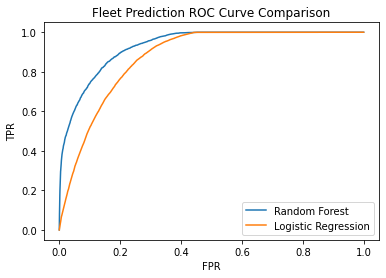

In [ ]:
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)


preds_rf_rdd = rf_preds.select('fleet','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['fleet'])))
points_rf_rdd = CurveMetrics(preds_rf_rdd).get_curve('roc')

x_val_rf = [x[0] for x in points_rf_rdd]
y_val_rf = [x[1] for x in points_rf_rdd]
plt.plot(x_val_rf, y_val_rf, label='Random Forest')

preds_lr_rdd = lr_preds.select('fleet','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['fleet'])))
points_lr_rdd = CurveMetrics(preds_lr_rdd).get_curve('roc')

x_val_lr = [x[0] for x in points_lr_rdd]
y_val_lr = [x[1] for x in points_lr_rdd]
plt.plot(x_val_lr, y_val_lr, label='Logistic Regression')

plt.title('Fleet Prediction ROC Curve Comparison')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

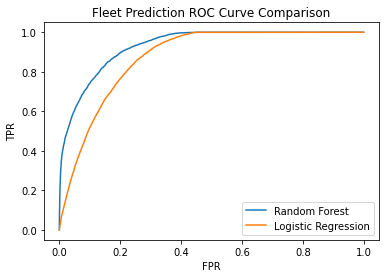

# Vehicle Options Logistic Regression

In [ ]:
tokenizer = feature.Tokenizer().setInputCol('major_options').setOutputCol('words')

cv = feature.CountVectorizer(minTF=1., minDF=5)\
  .setInputCol("words")\
  .setOutputCol("tf")

idf = feature.IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

if enable_grid:
  lr_options = LogisticRegression(labelCol='fleet',featuresCol='tfidf')

  grid_options = ParamGridBuilder().\
  addGrid(lr.regParam, [0., 0.01, 0.02, 0.03]).\
  addGrid(lr.elasticNetParam, [0., 0.1, 0.3]).\
  build()

  lr_pipe_options = Pipeline(stages = [tokenizer,cv,idf,lr_options]).fit(training_df)

  all_models = []
  for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = lr_pipe_options.fit(training_df, grid_options[j])
    all_models.append(model)
      
  scores =[]
  for m in all_models:
    score_lr_pipe_options = BinaryClassificationEvaluator(labelCol='fleet',metricName = 'areaUnderROC').evaluate(m.transform(validation_df))
    scores.append(score_lr_pipe_options)
        
  print(max(scores), '\n', grid_options[scores.index(max(scores))])
  pass

